# import the data

In [15]:
import pandas as pd

In [16]:
import os.path as path
DATA_DIR = path.join('datasets', 'titanic')

In [17]:
def import_data(filename):
    return pd.read_csv(path.join(DATA_DIR, filename))

In [18]:
train = import_data('train.csv')
test = import_data('test.csv')

# look around

In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
train.iloc[0]

PassengerId                          1
Survived                             0
Pclass                               3
Name           Braund, Mr. Owen Harris
Sex                               male
Age                                 22
SibSp                                1
Parch                                0
Ticket                       A/5 21171
Fare                              7.25
Cabin                              NaN
Embarked                             S
Name: 0, dtype: object

In [8]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D44D53E7B8>,
      dtype=object)

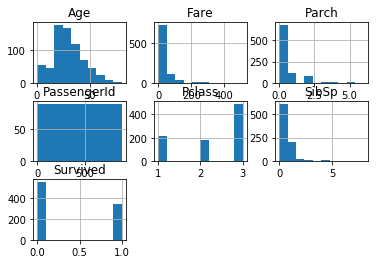

In [21]:
train.hist(bins=10)

In [22]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [14]:
train.corr()["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D44D60F828>,
      dtype=object)

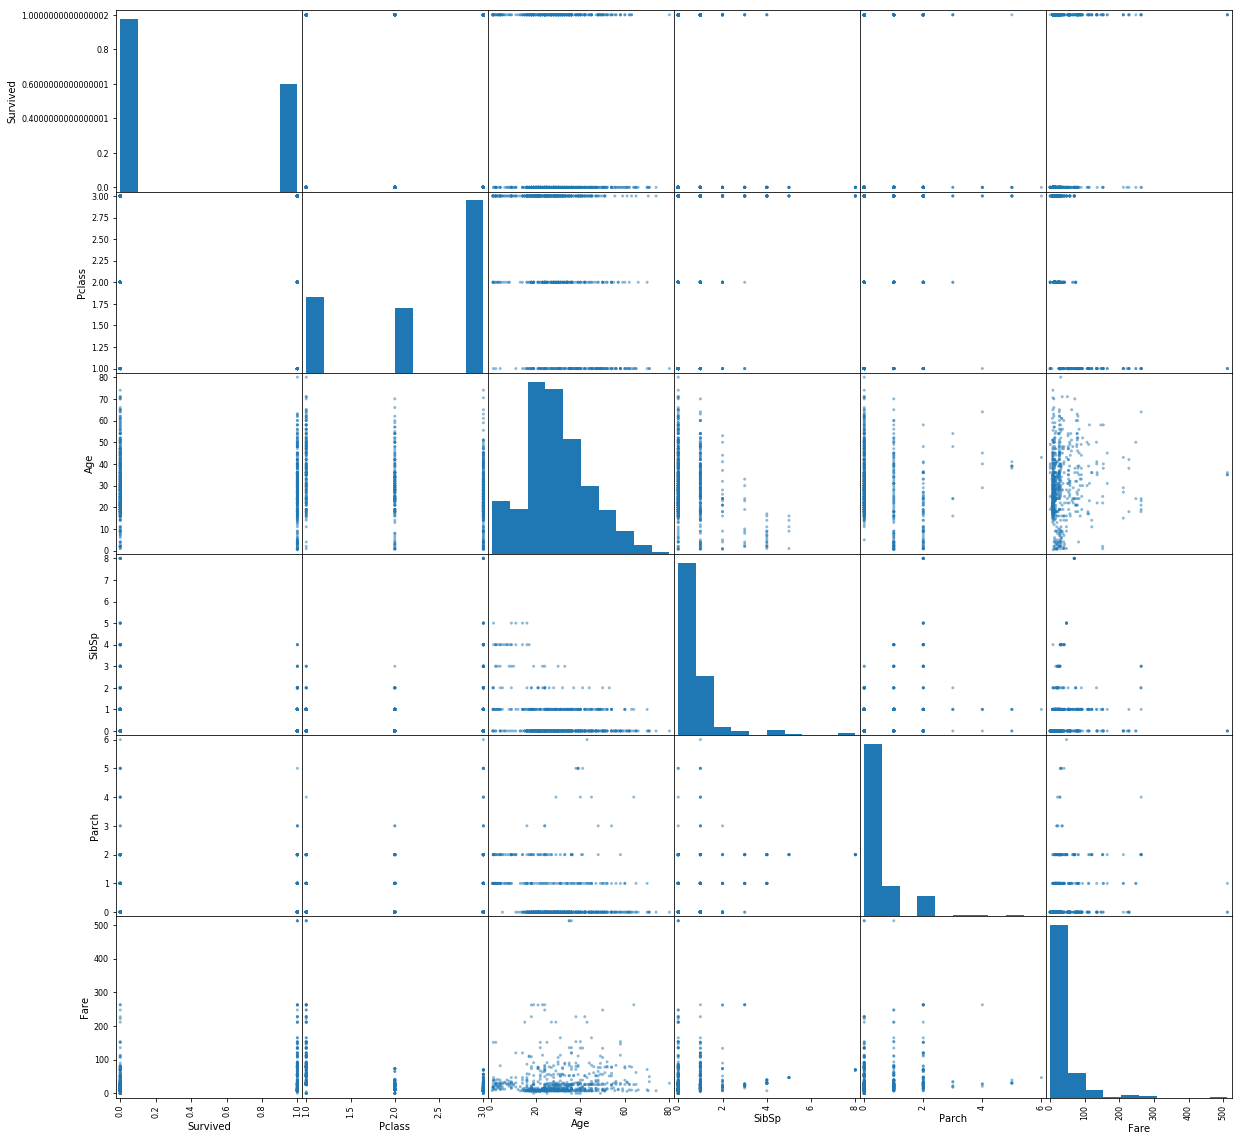

In [23]:
from pandas.plotting import scatter_matrix
scatter_matrix(train[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']], figsize=[20, 20])

# clean up the feature data

## pipeline for categorical data

In [232]:
# inspired by the class in the chapter, which in turn is inspired by some SO discussion,
# but I'm trying to write my own from how I remembered it...

# well, I had to fix up my class based on the other one, but at least I'm commenting what I've missed

# the class must inherit from TransformerMixin, so I can get the convenience fit_transform() method
# (which all transformers have) while only defining fit() and transform()
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator # might not be needed; see below

class MostFrequentImputer(
    # by inheriting from BaseEstimator I get get_params() and set_params(), something any good estimator should
    # apparently have; Chapter 2 says these "will be useful for automatic hyperparameter tuning."; it's important
    # to realise these get/set the hyperparameters, as opposed to *learned* params (like self.most_frequent_ below);
    # e.g. get_params() knows which params to output by introspection: it outputs the values of all the params that
    # the ctor takes (see the documentation); consider OneHotEncoder:
    # - create a default instance, OneHotEncoder()
    # - thanks to default params, this is equivalent to OneHotEncoder(
    #       categorical_features=None, categories=None,
    #       dtype=<class 'numpy.float64'>, handle_unknown='error',
    #       n_values=None, sparse=True)
    # - calling OnetHotEncoder().get_params() outputs something like
    #       {'categorical_features': None,
    #        'categories': None,
    #        'dtype': numpy.float64,
    #        'handle_unknown': 'error',
    #        'n_values': None,
    #        'sparse': True}
    # So this doesn't let me get at most_frequent_ after it's been fit. Sadly. Yet, it seems like a good practice
    # to inherit from BaseEstimator, so let's do so.
    BaseEstimator, 
    TransformerMixin):
    # no-op __init__ apparently not needed
    # def __init__(self):
    #     pass
    
    # do I need y=None? seems I can get away without it
    def fit(self, X):
        # nice touch: call this "most_frequent_" to signify an internal attribute, kind of like best_params_ on grid search
        self.most_frequent_ = pd.Series([X[column].value_counts().first_valid_index() for column in X]
                                       # important: name an index, otherwise fillna() in transform()
                                       # won't work: it won't be able to work out which default is for which column
                                       , index=X.columns
                                       )
        # don't forget to return self!!!
        return self
        
    def transform(self, X):
        return X.fillna(self.most_frequent_)

In [233]:
from sklearn.pipeline import Pipeline
cat_pipeline = Pipeline([
    ("imputer", MostFrequentImputer()),
    ("onehot", OneHotEncoder(sparse=False))
])

In [212]:
cat_matrix = cat_pipeline.fit_transform(train[['Sex', 'Embarked', 'Pclass']])

In [214]:
cat_matrix

array([[0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [209]:
cat_pipeline.steps[0][1].most_frequent_

Sex         male
Embarked       S
Pclass         3
dtype: object

In [221]:
# interpret the columns
[transform[1] for transform in cat_pipeline.steps if transform[0] == "onehot"][0].get_feature_names()

array(['x0_female', 'x0_male', 'x1_C', 'x1_Q', 'x1_S', 'x2_1', 'x2_2',
       'x2_3'], dtype=object)

## pipeline for numeric data

In [222]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

In [224]:
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

In [225]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [227]:
num_matrix = num_pipeline.fit_transform(train[['Age', 'SibSp', 'Parch', 'Fare']])

## relative adder

In [449]:
class RelativeAdder(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self
    
    def transform(self, X):
        return X.assign(Relatives=X['Parch'] + X['SibSp'], IsAlone=((X['Parch'] == 0) & (X['SibSp'] == 0)))

In [450]:
RelativeAdder().fit_transform(train)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,True
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,True
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0,True
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,4,False
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,2,False
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1,False


## age bucket adder

In [478]:
class AgeBucketAdder(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self
    def transform(self, X):
        return X.assign(AgeBucket=X['Age'].fillna(X['Age'].median()) // 15 * 15)

In [479]:
AgeBucketAdder().fit_transform(train)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBucket
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,15.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,15.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,30.0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,15.0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,45.0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0.0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,15.0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,0.0


## complete pipeline

In [480]:
from sklearn.compose import ColumnTransformer

In [481]:
pipeline = Pipeline([
    ('rel-adder', RelativeAdder()),
    ('age-adder', AgeBucketAdder()),
    ('col-xfmer', ColumnTransformer([
        ('num', num_pipeline, ['Age', 'SibSp', 'Parch']),
        ('cat1', OneHotEncoder(sparse=False), ['Sex', 'Pclass', 'IsAlone', 'AgeBucket']),
        ('cat2', Pipeline([
            ('most-frequent', MostFrequentImputer()),
            ('one-hot', OneHotEncoder(sparse=False))
             ]), ['Embarked']),
        #('cat3', OneHotEncoder(categories=[list(range(20)) for i in range(3)], sparse=False), ['SibSp', 'Parch', 'Relatives'])
        ]))
])

In [482]:
X_train = pipeline.fit_transform(train)
X_test = pipeline.fit_transform(test)

In [484]:
X_train[7]

array([-2.10273333,  2.24747049,  0.76762988,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ])

# get the labels

In [485]:
y_train = train['Survived']

In [486]:
y_train[7]

0

# science!

# evaluation helper

In [487]:
def export_data(data, filename):
    pd.DataFrame(list(zip(test['PassengerId'], data)), columns=['PassengerId', 'Survived']).to_csv(path.join(DATA_DIR, filename), index=False)

In [488]:
def eval_and_save(estimator, filename):
    estimator.fit(X_train, y_train)
    print(cross_val_score(estimator, X_train, y_train, cv=10).mean())
    export_data(estimator.predict(X_test), filename)

## SGD

In [489]:
from sklearn.linear_model import SGDClassifier
eval_and_save(SGDClassifier(random_state=42, max_iter=8), 'sgd.csv')

0.7678365111792078


## SVC

In [490]:
from sklearn.svm import SVC
eval_and_save(SVC(gamma='auto'), 'svc.csv')

0.8294345136760868


## Forest

In [491]:
from sklearn.ensemble import RandomForestClassifier
eval_and_save(RandomForestClassifier(random_state=42, n_estimators=100), 'random_forest.csv')

0.8015318919532401
